# Kandinsky GAN (DCGAN Implementation)

Implementing a simple pytorch DCGAN (based off the soumith chintala tutorial). Hoping to create some Kandinsky paintings from a dataset of 305 scraped JPEGs of Kandinsky's paintings. 

In [300]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

manualSeed = 999
print("Random seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random seed:  999


In [329]:
dataroot = '/Users/nikolaslaskaris/Documents/projects/art_mdls/kandinsky_jpegs'

workers = 2
batch_size = 1
image_size = 64
# number of channels in training images
nc = 3

# size of z latent vector
nz = 50

# Feature maps size in generator
ngf = 64

# Discriminator maps size
ndf = 64

# learning_rate
lr = 0.0001

# Beta1 for ADAM optimizers
beta1=0.5

ngpu = 0

In [330]:
dataset = dset.ImageFolder(root=dataroot,
                          transform=transforms.Compose([
                              transforms.Resize(image_size),
                              transforms.CenterCrop(image_size),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                          ]))

In [331]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                        shuffle=True, num_workers=workers)

In [332]:
device = torch.device('cpu')

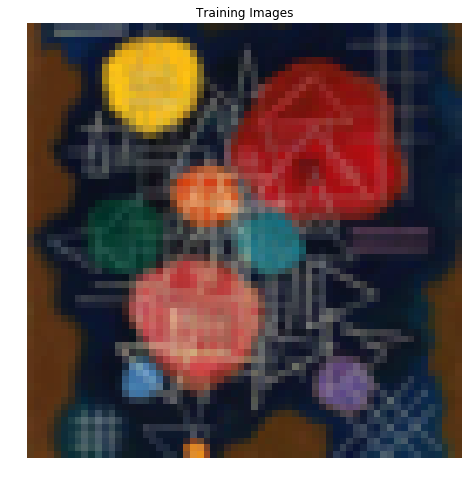

In [370]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0],
                                        padding=2, normalize=True).cpu(),(1,2,0)))

We're using a 64x64 resolution for the jpegs, mostly because GANs are usually much harder to train with larger image sizes. If we get good results we'll play around with increasing the size in future experiments.

## Implementation of DCGAN

In [334]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [335]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [336]:
# Create the generator
netG = Generator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(50, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [337]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [338]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)


# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [339]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(1, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [344]:
# Training epochs
num_epochs = 500

In [345]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # fake batch training, generate latent vectors 
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1


Starting Training Loop...
[0/500][0/304]	Loss_D: 0.0800	Loss_G: 6.3905	D(x): 1.0000	D(G(z)): 0.0769 / 0.0017
[0/500][50/304]	Loss_D: 0.1910	Loss_G: 3.8385	D(x): 0.8525	D(G(z)): 0.0309 / 0.0215
[0/500][100/304]	Loss_D: 0.0279	Loss_G: 5.2920	D(x): 0.9979	D(G(z)): 0.0255 / 0.0050
[0/500][150/304]	Loss_D: 0.0029	Loss_G: 17.8482	D(x): 0.9971	D(G(z)): 0.0000 / 0.0000
[0/500][200/304]	Loss_D: 0.1630	Loss_G: 5.6541	D(x): 1.0000	D(G(z)): 0.1504 / 0.0035
[0/500][250/304]	Loss_D: 0.0668	Loss_G: 3.8672	D(x): 1.0000	D(G(z)): 0.0646 / 0.0209
[0/500][300/304]	Loss_D: 0.0002	Loss_G: 9.5515	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1/500][0/304]	Loss_D: 0.1655	Loss_G: 4.3051	D(x): 1.0000	D(G(z)): 0.1525 / 0.0135
[1/500][50/304]	Loss_D: 0.0797	Loss_G: 5.0010	D(x): 0.9998	D(G(z)): 0.0765 / 0.0067
[1/500][100/304]	Loss_D: 0.0541	Loss_G: 4.7827	D(x): 1.0000	D(G(z)): 0.0527 / 0.0084
[1/500][150/304]	Loss_D: 0.0193	Loss_G: 5.2624	D(x): 1.0000	D(G(z)): 0.0192 / 0.0052
[1/500][200/304]	Loss_D: 0.0255	Loss_G: 4.81

[13/500][300/304]	Loss_D: 0.9353	Loss_G: 8.6212	D(x): 0.9999	D(G(z)): 0.6075 / 0.0002
[14/500][0/304]	Loss_D: 0.0020	Loss_G: 6.6096	D(x): 1.0000	D(G(z)): 0.0020 / 0.0013
[14/500][50/304]	Loss_D: 0.0151	Loss_G: 4.5878	D(x): 1.0000	D(G(z)): 0.0150 / 0.0102
[14/500][100/304]	Loss_D: 0.0033	Loss_G: 9.7116	D(x): 0.9968	D(G(z)): 0.0001 / 0.0001
[14/500][150/304]	Loss_D: 0.0276	Loss_G: 4.5062	D(x): 0.9894	D(G(z)): 0.0169 / 0.0110
[14/500][200/304]	Loss_D: 0.0069	Loss_G: 5.9704	D(x): 1.0000	D(G(z)): 0.0069 / 0.0026
[14/500][250/304]	Loss_D: 0.0438	Loss_G: 4.4448	D(x): 0.9840	D(G(z)): 0.0273 / 0.0117
[14/500][300/304]	Loss_D: 0.0191	Loss_G: 4.7259	D(x): 1.0000	D(G(z)): 0.0189 / 0.0089
[15/500][0/304]	Loss_D: 0.0237	Loss_G: 4.8646	D(x): 0.9999	D(G(z)): 0.0233 / 0.0077
[15/500][50/304]	Loss_D: 0.0103	Loss_G: 5.3755	D(x): 0.9997	D(G(z)): 0.0099 / 0.0046
[15/500][100/304]	Loss_D: 0.0727	Loss_G: 4.6571	D(x): 0.9476	D(G(z)): 0.0187 / 0.0095
[15/500][150/304]	Loss_D: 0.0650	Loss_G: 4.6429	D(x): 0.9981

[27/500][200/304]	Loss_D: 0.0284	Loss_G: 4.6028	D(x): 0.9999	D(G(z)): 0.0279 / 0.0100
[27/500][250/304]	Loss_D: 0.0256	Loss_G: 4.4322	D(x): 1.0000	D(G(z)): 0.0253 / 0.0119
[27/500][300/304]	Loss_D: 0.0231	Loss_G: 4.5829	D(x): 1.0000	D(G(z)): 0.0229 / 0.0102
[28/500][0/304]	Loss_D: 0.0329	Loss_G: 4.3239	D(x): 1.0000	D(G(z)): 0.0323 / 0.0132
[28/500][50/304]	Loss_D: 0.0543	Loss_G: 5.1183	D(x): 0.9587	D(G(z)): 0.0121 / 0.0060
[28/500][100/304]	Loss_D: 0.0252	Loss_G: 4.9280	D(x): 0.9877	D(G(z)): 0.0127 / 0.0072
[28/500][150/304]	Loss_D: 0.1331	Loss_G: 5.0809	D(x): 1.0000	D(G(z)): 0.1246 / 0.0062
[28/500][200/304]	Loss_D: 0.0197	Loss_G: 5.0174	D(x): 0.9975	D(G(z)): 0.0171 / 0.0066
[28/500][250/304]	Loss_D: 0.0418	Loss_G: 4.4932	D(x): 0.9942	D(G(z)): 0.0353 / 0.0112
[28/500][300/304]	Loss_D: 0.0216	Loss_G: 4.8993	D(x): 1.0000	D(G(z)): 0.0213 / 0.0075
[29/500][0/304]	Loss_D: 0.0462	Loss_G: 4.5399	D(x): 1.0000	D(G(z)): 0.0452 / 0.0107
[29/500][50/304]	Loss_D: 0.0289	Loss_G: 4.6300	D(x): 0.9923

[41/500][100/304]	Loss_D: 0.1333	Loss_G: 4.0987	D(x): 1.0000	D(G(z)): 0.1248 / 0.0166
[41/500][150/304]	Loss_D: 0.0275	Loss_G: 4.8513	D(x): 1.0000	D(G(z)): 0.0271 / 0.0078
[41/500][200/304]	Loss_D: 0.0330	Loss_G: 4.3953	D(x): 1.0000	D(G(z)): 0.0324 / 0.0123
[41/500][250/304]	Loss_D: 0.0047	Loss_G: 7.2303	D(x): 0.9961	D(G(z)): 0.0007 / 0.0007
[41/500][300/304]	Loss_D: 0.0310	Loss_G: 4.9709	D(x): 0.9995	D(G(z)): 0.0301 / 0.0069
[42/500][0/304]	Loss_D: 0.0080	Loss_G: 5.2614	D(x): 1.0000	D(G(z)): 0.0080 / 0.0052
[42/500][50/304]	Loss_D: 0.0407	Loss_G: 5.3846	D(x): 0.9996	D(G(z)): 0.0395 / 0.0046
[42/500][100/304]	Loss_D: 0.0099	Loss_G: 5.1739	D(x): 1.0000	D(G(z)): 0.0098 / 0.0057
[42/500][150/304]	Loss_D: 0.5522	Loss_G: 16.6429	D(x): 0.9881	D(G(z)): 0.4174 / 0.0000
[42/500][200/304]	Loss_D: 0.0601	Loss_G: 4.5777	D(x): 0.9993	D(G(z)): 0.0576 / 0.0103
[42/500][250/304]	Loss_D: 0.7271	Loss_G: 3.2576	D(x): 0.5067	D(G(z)): 0.0461 / 0.0385
[42/500][300/304]	Loss_D: 0.0557	Loss_G: 3.9056	D(x): 0.

[55/500][0/304]	Loss_D: 0.0514	Loss_G: 5.0037	D(x): 1.0000	D(G(z)): 0.0501 / 0.0067
[55/500][50/304]	Loss_D: 0.0132	Loss_G: 5.2780	D(x): 1.0000	D(G(z)): 0.0131 / 0.0051
[55/500][100/304]	Loss_D: 0.0165	Loss_G: 5.3160	D(x): 1.0000	D(G(z)): 0.0163 / 0.0049
[55/500][150/304]	Loss_D: 0.0182	Loss_G: 5.0099	D(x): 0.9999	D(G(z)): 0.0179 / 0.0067
[55/500][200/304]	Loss_D: 0.0157	Loss_G: 6.0864	D(x): 0.9980	D(G(z)): 0.0136 / 0.0023
[55/500][250/304]	Loss_D: 0.0227	Loss_G: 4.9532	D(x): 1.0000	D(G(z)): 0.0224 / 0.0071
[55/500][300/304]	Loss_D: 0.0228	Loss_G: 4.6697	D(x): 1.0000	D(G(z)): 0.0225 / 0.0094
[56/500][0/304]	Loss_D: 0.0177	Loss_G: 4.8849	D(x): 1.0000	D(G(z)): 0.0175 / 0.0076
[56/500][50/304]	Loss_D: 0.0174	Loss_G: 4.8581	D(x): 0.9977	D(G(z)): 0.0150 / 0.0078
[56/500][100/304]	Loss_D: 0.0239	Loss_G: 4.8598	D(x): 1.0000	D(G(z)): 0.0236 / 0.0078
[56/500][150/304]	Loss_D: 0.0087	Loss_G: 5.3184	D(x): 0.9995	D(G(z)): 0.0082 / 0.0049
[56/500][200/304]	Loss_D: 0.0265	Loss_G: 4.9944	D(x): 1.0000

[68/500][250/304]	Loss_D: 0.0196	Loss_G: 4.6382	D(x): 1.0000	D(G(z)): 0.0194 / 0.0097
[68/500][300/304]	Loss_D: 0.0103	Loss_G: 5.1144	D(x): 1.0000	D(G(z)): 0.0102 / 0.0060
[69/500][0/304]	Loss_D: 0.0380	Loss_G: 3.8608	D(x): 1.0000	D(G(z)): 0.0373 / 0.0211
[69/500][50/304]	Loss_D: 0.0125	Loss_G: 5.0641	D(x): 1.0000	D(G(z)): 0.0124 / 0.0063
[69/500][100/304]	Loss_D: 0.0128	Loss_G: 5.3822	D(x): 0.9993	D(G(z)): 0.0120 / 0.0046
[69/500][150/304]	Loss_D: 0.0177	Loss_G: 5.0665	D(x): 0.9997	D(G(z)): 0.0172 / 0.0063
[69/500][200/304]	Loss_D: 0.0381	Loss_G: 4.3062	D(x): 1.0000	D(G(z)): 0.0374 / 0.0135
[69/500][250/304]	Loss_D: 0.7766	Loss_G: 2.6114	D(x): 0.4675	D(G(z)): 0.0161 / 0.0734
[69/500][300/304]	Loss_D: 0.0148	Loss_G: 4.9576	D(x): 1.0000	D(G(z)): 0.0147 / 0.0070
[70/500][0/304]	Loss_D: 0.0200	Loss_G: 5.0094	D(x): 0.9989	D(G(z)): 0.0188 / 0.0067
[70/500][50/304]	Loss_D: 0.0114	Loss_G: 5.0976	D(x): 1.0000	D(G(z)): 0.0113 / 0.0061
[70/500][100/304]	Loss_D: 0.0168	Loss_G: 4.9212	D(x): 1.0000

[82/500][150/304]	Loss_D: 0.0569	Loss_G: 5.2805	D(x): 1.0000	D(G(z)): 0.0553 / 0.0051
[82/500][200/304]	Loss_D: 0.0003	Loss_G: 16.0862	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[82/500][250/304]	Loss_D: 0.0116	Loss_G: 5.3854	D(x): 1.0000	D(G(z)): 0.0115 / 0.0046
[82/500][300/304]	Loss_D: 0.0203	Loss_G: 5.0970	D(x): 0.9953	D(G(z)): 0.0155 / 0.0061
[83/500][0/304]	Loss_D: 0.0352	Loss_G: 4.6429	D(x): 0.9997	D(G(z)): 0.0343 / 0.0096
[83/500][50/304]	Loss_D: 0.0279	Loss_G: 5.0282	D(x): 0.9848	D(G(z)): 0.0124 / 0.0066
[83/500][100/304]	Loss_D: 0.0495	Loss_G: 5.3534	D(x): 0.9722	D(G(z)): 0.0211 / 0.0047
[83/500][150/304]	Loss_D: 0.0136	Loss_G: 5.0260	D(x): 1.0000	D(G(z)): 0.0135 / 0.0066
[83/500][200/304]	Loss_D: 0.0279	Loss_G: 4.9456	D(x): 0.9902	D(G(z)): 0.0179 / 0.0071
[83/500][250/304]	Loss_D: 0.0156	Loss_G: 4.8819	D(x): 1.0000	D(G(z)): 0.0155 / 0.0076
[83/500][300/304]	Loss_D: 0.0167	Loss_G: 4.8865	D(x): 0.9994	D(G(z)): 0.0160 / 0.0075
[84/500][0/304]	Loss_D: 0.0315	Loss_G: 4.6948	D(x): 0.98

[96/500][50/304]	Loss_D: 0.0172	Loss_G: 5.0315	D(x): 1.0000	D(G(z)): 0.0171 / 0.0065
[96/500][100/304]	Loss_D: 0.0124	Loss_G: 5.0393	D(x): 1.0000	D(G(z)): 0.0123 / 0.0065
[96/500][150/304]	Loss_D: 0.0079	Loss_G: 5.2012	D(x): 1.0000	D(G(z)): 0.0078 / 0.0055
[96/500][200/304]	Loss_D: 0.0065	Loss_G: 5.4433	D(x): 0.9987	D(G(z)): 0.0052 / 0.0043
[96/500][250/304]	Loss_D: 0.0042	Loss_G: 5.7351	D(x): 0.9995	D(G(z)): 0.0037 / 0.0032
[96/500][300/304]	Loss_D: 0.0550	Loss_G: 5.1272	D(x): 0.9930	D(G(z)): 0.0468 / 0.0059
[97/500][0/304]	Loss_D: 0.0286	Loss_G: 5.2003	D(x): 0.9998	D(G(z)): 0.0279 / 0.0055
[97/500][50/304]	Loss_D: 0.0951	Loss_G: 4.6453	D(x): 0.9167	D(G(z)): 0.0081 / 0.0096
[97/500][100/304]	Loss_D: 0.0850	Loss_G: 5.4280	D(x): 0.9278	D(G(z)): 0.0099 / 0.0044
[97/500][150/304]	Loss_D: 0.0001	Loss_G: 9.9927	D(x): 1.0000	D(G(z)): 0.0001 / 0.0000
[97/500][200/304]	Loss_D: 0.0073	Loss_G: 5.1762	D(x): 0.9999	D(G(z)): 0.0073 / 0.0056
[97/500][250/304]	Loss_D: 0.0215	Loss_G: 5.0991	D(x): 1.00

[109/500][250/304]	Loss_D: 0.0428	Loss_G: 4.7468	D(x): 0.9741	D(G(z)): 0.0165 / 0.0087
[109/500][300/304]	Loss_D: 0.0184	Loss_G: 5.1341	D(x): 1.0000	D(G(z)): 0.0182 / 0.0059
[110/500][0/304]	Loss_D: 0.0191	Loss_G: 4.9226	D(x): 1.0000	D(G(z)): 0.0189 / 0.0073
[110/500][50/304]	Loss_D: 0.0533	Loss_G: 5.3885	D(x): 1.0000	D(G(z)): 0.0519 / 0.0046
[110/500][100/304]	Loss_D: 0.0147	Loss_G: 5.2449	D(x): 1.0000	D(G(z)): 0.0146 / 0.0053
[110/500][150/304]	Loss_D: 0.0010	Loss_G: 6.9481	D(x): 1.0000	D(G(z)): 0.0010 / 0.0010
[110/500][200/304]	Loss_D: 0.0500	Loss_G: 4.5206	D(x): 1.0000	D(G(z)): 0.0488 / 0.0109
[110/500][250/304]	Loss_D: 0.0129	Loss_G: 4.9924	D(x): 0.9999	D(G(z)): 0.0127 / 0.0068
[110/500][300/304]	Loss_D: 0.0153	Loss_G: 4.8312	D(x): 1.0000	D(G(z)): 0.0152 / 0.0080
[111/500][0/304]	Loss_D: 0.0112	Loss_G: 5.0595	D(x): 1.0000	D(G(z)): 0.0111 / 0.0063
[111/500][50/304]	Loss_D: 0.0274	Loss_G: 4.2599	D(x): 1.0000	D(G(z)): 0.0271 / 0.0141
[111/500][100/304]	Loss_D: 0.0085	Loss_G: 5.0988	

[123/500][100/304]	Loss_D: 0.0002	Loss_G: 8.5722	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[123/500][150/304]	Loss_D: 0.0010	Loss_G: 6.9121	D(x): 1.0000	D(G(z)): 0.0010 / 0.0010
[123/500][200/304]	Loss_D: 0.0009	Loss_G: 6.9968	D(x): 1.0000	D(G(z)): 0.0009 / 0.0009
[123/500][250/304]	Loss_D: 0.0013	Loss_G: 6.9996	D(x): 0.9996	D(G(z)): 0.0009 / 0.0009
[123/500][300/304]	Loss_D: 0.0048	Loss_G: 5.4250	D(x): 1.0000	D(G(z)): 0.0048 / 0.0044
[124/500][0/304]	Loss_D: 0.0041	Loss_G: 5.5711	D(x): 1.0000	D(G(z)): 0.0041 / 0.0038
[124/500][50/304]	Loss_D: 0.0016	Loss_G: 6.4407	D(x): 1.0000	D(G(z)): 0.0016 / 0.0016
[124/500][100/304]	Loss_D: 0.0041	Loss_G: 5.5721	D(x): 1.0000	D(G(z)): 0.0041 / 0.0038
[124/500][150/304]	Loss_D: 0.0029	Loss_G: 5.8915	D(x): 0.9999	D(G(z)): 0.0029 / 0.0028
[124/500][200/304]	Loss_D: 0.0012	Loss_G: 6.7733	D(x): 1.0000	D(G(z)): 0.0012 / 0.0011
[124/500][250/304]	Loss_D: 0.0009	Loss_G: 7.0604	D(x): 1.0000	D(G(z)): 0.0009 / 0.0009
[124/500][300/304]	Loss_D: 0.0007	Loss_G: 7.27

[136/500][300/304]	Loss_D: 0.0004	Loss_G: 8.8609	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001
[137/500][0/304]	Loss_D: 0.0164	Loss_G: 4.8473	D(x): 0.9929	D(G(z)): 0.0092 / 0.0078
[137/500][50/304]	Loss_D: 0.0105	Loss_G: 4.9625	D(x): 0.9978	D(G(z)): 0.0083 / 0.0070
[137/500][100/304]	Loss_D: 0.0420	Loss_G: 4.3106	D(x): 1.0000	D(G(z)): 0.0411 / 0.0134
[137/500][150/304]	Loss_D: 0.0065	Loss_G: 5.2310	D(x): 1.0000	D(G(z)): 0.0064 / 0.0053
[137/500][200/304]	Loss_D: 0.0374	Loss_G: 4.0583	D(x): 1.0000	D(G(z)): 0.0367 / 0.0173
[137/500][250/304]	Loss_D: 7.7332	Loss_G: 3.0792	D(x): 0.0004	D(G(z)): 0.0038 / 0.0460
[137/500][300/304]	Loss_D: 0.0033	Loss_G: 5.7661	D(x): 1.0000	D(G(z)): 0.0033 / 0.0031
[138/500][0/304]	Loss_D: 0.0030	Loss_G: 5.8723	D(x): 1.0000	D(G(z)): 0.0030 / 0.0028
[138/500][50/304]	Loss_D: 0.0219	Loss_G: 4.7557	D(x): 1.0000	D(G(z)): 0.0217 / 0.0086
[138/500][100/304]	Loss_D: 0.0065	Loss_G: 5.3384	D(x): 1.0000	D(G(z)): 0.0065 / 0.0048
[138/500][150/304]	Loss_D: 0.0299	Loss_G: 5.1424	

[150/500][150/304]	Loss_D: 0.0104	Loss_G: 4.9775	D(x): 1.0000	D(G(z)): 0.0103 / 0.0069
[150/500][200/304]	Loss_D: 0.0306	Loss_G: 4.7277	D(x): 1.0000	D(G(z)): 0.0301 / 0.0088
[150/500][250/304]	Loss_D: 0.0596	Loss_G: 3.5101	D(x): 1.0000	D(G(z)): 0.0578 / 0.0299
[150/500][300/304]	Loss_D: 0.0465	Loss_G: 4.6782	D(x): 1.0000	D(G(z)): 0.0454 / 0.0093
[151/500][0/304]	Loss_D: 0.0428	Loss_G: 4.8557	D(x): 0.9993	D(G(z)): 0.0413 / 0.0078
[151/500][50/304]	Loss_D: 0.0348	Loss_G: 4.5517	D(x): 0.9942	D(G(z)): 0.0285 / 0.0105
[151/500][100/304]	Loss_D: 0.0144	Loss_G: 4.7829	D(x): 0.9999	D(G(z)): 0.0143 / 0.0084
[151/500][150/304]	Loss_D: 0.0216	Loss_G: 4.6862	D(x): 1.0000	D(G(z)): 0.0213 / 0.0092
[151/500][200/304]	Loss_D: 0.0135	Loss_G: 5.1866	D(x): 1.0000	D(G(z)): 0.0134 / 0.0056
[151/500][250/304]	Loss_D: 0.0049	Loss_G: 5.6907	D(x): 1.0000	D(G(z)): 0.0049 / 0.0034
[151/500][300/304]	Loss_D: 0.0681	Loss_G: 5.3591	D(x): 0.9397	D(G(z)): 0.0059 / 0.0047
[152/500][0/304]	Loss_D: 0.0099	Loss_G: 5.1230

[164/500][0/304]	Loss_D: 0.0056	Loss_G: 5.5375	D(x): 1.0000	D(G(z)): 0.0056 / 0.0039
[164/500][50/304]	Loss_D: 0.0141	Loss_G: 4.8459	D(x): 0.9996	D(G(z)): 0.0136 / 0.0079
[164/500][100/304]	Loss_D: 0.0031	Loss_G: 5.9605	D(x): 0.9999	D(G(z)): 0.0030 / 0.0026
[164/500][150/304]	Loss_D: 0.0034	Loss_G: 5.8262	D(x): 1.0000	D(G(z)): 0.0034 / 0.0029
[164/500][200/304]	Loss_D: 0.0282	Loss_G: 5.0059	D(x): 1.0000	D(G(z)): 0.0278 / 0.0067
[164/500][250/304]	Loss_D: 0.0048	Loss_G: 5.6474	D(x): 1.0000	D(G(z)): 0.0048 / 0.0035
[164/500][300/304]	Loss_D: 0.0648	Loss_G: 4.6152	D(x): 0.9988	D(G(z)): 0.0617 / 0.0099
[165/500][0/304]	Loss_D: 0.0172	Loss_G: 5.3518	D(x): 0.9942	D(G(z)): 0.0114 / 0.0047
[165/500][50/304]	Loss_D: 0.0180	Loss_G: 5.0483	D(x): 1.0000	D(G(z)): 0.0179 / 0.0064
[165/500][100/304]	Loss_D: 0.0155	Loss_G: 5.2404	D(x): 1.0000	D(G(z)): 0.0154 / 0.0053
[165/500][150/304]	Loss_D: 0.0086	Loss_G: 5.3115	D(x): 1.0000	D(G(z)): 0.0086 / 0.0049
[165/500][200/304]	Loss_D: 0.0642	Loss_G: 5.6022	

[177/500][200/304]	Loss_D: 0.0098	Loss_G: 5.2190	D(x): 1.0000	D(G(z)): 0.0097 / 0.0054
[177/500][250/304]	Loss_D: 0.0083	Loss_G: 5.2680	D(x): 1.0000	D(G(z)): 0.0082 / 0.0052
[177/500][300/304]	Loss_D: 0.0668	Loss_G: 5.0775	D(x): 1.0000	D(G(z)): 0.0646 / 0.0062
[178/500][0/304]	Loss_D: 0.0040	Loss_G: 5.9337	D(x): 1.0000	D(G(z)): 0.0040 / 0.0026
[178/500][50/304]	Loss_D: 0.0135	Loss_G: 5.2150	D(x): 1.0000	D(G(z)): 0.0134 / 0.0054
[178/500][100/304]	Loss_D: 0.0636	Loss_G: 5.0890	D(x): 0.9442	D(G(z)): 0.0061 / 0.0062
[178/500][150/304]	Loss_D: 0.0072	Loss_G: 5.2534	D(x): 1.0000	D(G(z)): 0.0072 / 0.0052
[178/500][200/304]	Loss_D: 0.0168	Loss_G: 4.9050	D(x): 0.9995	D(G(z)): 0.0162 / 0.0074
[178/500][250/304]	Loss_D: 0.0327	Loss_G: 5.1928	D(x): 0.9971	D(G(z)): 0.0293 / 0.0056
[178/500][300/304]	Loss_D: 0.0242	Loss_G: 4.8349	D(x): 0.9903	D(G(z)): 0.0144 / 0.0079
[179/500][0/304]	Loss_D: 0.0123	Loss_G: 5.0126	D(x): 0.9999	D(G(z)): 0.0121 / 0.0067
[179/500][50/304]	Loss_D: 0.0110	Loss_G: 5.0582	

[191/500][50/304]	Loss_D: 0.0184	Loss_G: 4.6773	D(x): 1.0000	D(G(z)): 0.0182 / 0.0093
[191/500][100/304]	Loss_D: 0.0147	Loss_G: 5.0258	D(x): 1.0000	D(G(z)): 0.0146 / 0.0066
[191/500][150/304]	Loss_D: 0.0140	Loss_G: 4.9920	D(x): 1.0000	D(G(z)): 0.0139 / 0.0068
[191/500][200/304]	Loss_D: 0.0138	Loss_G: 4.8392	D(x): 0.9998	D(G(z)): 0.0135 / 0.0079
[191/500][250/304]	Loss_D: 0.0315	Loss_G: 4.1285	D(x): 0.9999	D(G(z)): 0.0309 / 0.0161
[191/500][300/304]	Loss_D: 0.0073	Loss_G: 5.2147	D(x): 1.0000	D(G(z)): 0.0073 / 0.0054
[192/500][0/304]	Loss_D: 0.0051	Loss_G: 5.5158	D(x): 1.0000	D(G(z)): 0.0051 / 0.0040
[192/500][50/304]	Loss_D: 0.0137	Loss_G: 4.9786	D(x): 1.0000	D(G(z)): 0.0136 / 0.0069
[192/500][100/304]	Loss_D: 0.0075	Loss_G: 5.5389	D(x): 0.9999	D(G(z)): 0.0074 / 0.0039
[192/500][150/304]	Loss_D: 1.7434	Loss_G: 0.7161	D(x): 0.1766	D(G(z)): 0.0094 / 0.4886
[192/500][200/304]	Loss_D: 0.0163	Loss_G: 4.6105	D(x): 1.0000	D(G(z)): 0.0161 / 0.0099
[192/500][250/304]	Loss_D: 0.1604	Loss_G: 4.800

[204/500][250/304]	Loss_D: 0.0027	Loss_G: 6.6874	D(x): 0.9996	D(G(z)): 0.0023 / 0.0012
[204/500][300/304]	Loss_D: 0.0052	Loss_G: 5.5432	D(x): 1.0000	D(G(z)): 0.0052 / 0.0039
[205/500][0/304]	Loss_D: 0.0069	Loss_G: 5.2953	D(x): 1.0000	D(G(z)): 0.0069 / 0.0050
[205/500][50/304]	Loss_D: 0.0252	Loss_G: 4.4989	D(x): 1.0000	D(G(z)): 0.0248 / 0.0111
[205/500][100/304]	Loss_D: 0.0207	Loss_G: 4.5093	D(x): 1.0000	D(G(z)): 0.0205 / 0.0110
[205/500][150/304]	Loss_D: 0.0052	Loss_G: 5.7745	D(x): 0.9999	D(G(z)): 0.0052 / 0.0031
[205/500][200/304]	Loss_D: 0.0130	Loss_G: 5.1802	D(x): 0.9992	D(G(z)): 0.0121 / 0.0056
[205/500][250/304]	Loss_D: 0.0196	Loss_G: 5.0260	D(x): 1.0000	D(G(z)): 0.0194 / 0.0066
[205/500][300/304]	Loss_D: 0.0085	Loss_G: 5.1833	D(x): 0.9999	D(G(z)): 0.0083 / 0.0056
[206/500][0/304]	Loss_D: 0.0082	Loss_G: 5.2195	D(x): 1.0000	D(G(z)): 0.0081 / 0.0054
[206/500][50/304]	Loss_D: 0.0069	Loss_G: 5.2759	D(x): 1.0000	D(G(z)): 0.0069 / 0.0051
[206/500][100/304]	Loss_D: 0.0065	Loss_G: 5.3302	

[218/500][100/304]	Loss_D: 0.0326	Loss_G: 5.7230	D(x): 0.9781	D(G(z)): 0.0104 / 0.0033
[218/500][150/304]	Loss_D: 13.4858	Loss_G: 4.1212	D(x): 0.0000	D(G(z)): 0.5507 / 0.0162
[218/500][200/304]	Loss_D: 0.0160	Loss_G: 4.6962	D(x): 1.0000	D(G(z)): 0.0159 / 0.0091
[218/500][250/304]	Loss_D: 0.0108	Loss_G: 4.9607	D(x): 1.0000	D(G(z)): 0.0107 / 0.0070
[218/500][300/304]	Loss_D: 0.0137	Loss_G: 4.9599	D(x): 1.0000	D(G(z)): 0.0136 / 0.0070
[219/500][0/304]	Loss_D: 0.0119	Loss_G: 5.0370	D(x): 1.0000	D(G(z)): 0.0118 / 0.0065
[219/500][50/304]	Loss_D: 0.0244	Loss_G: 4.8065	D(x): 1.0000	D(G(z)): 0.0240 / 0.0082
[219/500][100/304]	Loss_D: 0.0223	Loss_G: 4.6668	D(x): 1.0000	D(G(z)): 0.0220 / 0.0094
[219/500][150/304]	Loss_D: 0.2275	Loss_G: 4.3520	D(x): 0.9996	D(G(z)): 0.2031 / 0.0129
[219/500][200/304]	Loss_D: 0.0156	Loss_G: 4.8920	D(x): 0.9998	D(G(z)): 0.0153 / 0.0075
[219/500][250/304]	Loss_D: 0.0120	Loss_G: 4.8909	D(x): 1.0000	D(G(z)): 0.0120 / 0.0075
[219/500][300/304]	Loss_D: 0.0065	Loss_G: 5.2

[231/500][300/304]	Loss_D: 0.0054	Loss_G: 5.3188	D(x): 0.9999	D(G(z)): 0.0053 / 0.0049
[232/500][0/304]	Loss_D: 0.0051	Loss_G: 5.3603	D(x): 0.9999	D(G(z)): 0.0050 / 0.0047
[232/500][50/304]	Loss_D: 0.0047	Loss_G: 5.4274	D(x): 1.0000	D(G(z)): 0.0046 / 0.0044
[232/500][100/304]	Loss_D: 0.0019	Loss_G: 6.2750	D(x): 1.0000	D(G(z)): 0.0019 / 0.0019
[232/500][150/304]	Loss_D: 0.0012	Loss_G: 6.7774	D(x): 1.0000	D(G(z)): 0.0012 / 0.0011
[232/500][200/304]	Loss_D: 0.0028	Loss_G: 5.9114	D(x): 1.0000	D(G(z)): 0.0028 / 0.0027
[232/500][250/304]	Loss_D: 0.0030	Loss_G: 6.5412	D(x): 0.9985	D(G(z)): 0.0015 / 0.0014
[232/500][300/304]	Loss_D: 0.0010	Loss_G: 6.9168	D(x): 1.0000	D(G(z)): 0.0010 / 0.0010
[233/500][0/304]	Loss_D: 0.0010	Loss_G: 6.9153	D(x): 1.0000	D(G(z)): 0.0010 / 0.0010
[233/500][50/304]	Loss_D: 0.0013	Loss_G: 6.6648	D(x): 1.0000	D(G(z)): 0.0013 / 0.0013
[233/500][100/304]	Loss_D: 0.0050	Loss_G: 5.3854	D(x): 1.0000	D(G(z)): 0.0050 / 0.0046
[233/500][150/304]	Loss_D: 0.0015	Loss_G: 6.4989	

[245/500][150/304]	Loss_D: 0.0363	Loss_G: 4.5847	D(x): 0.9813	D(G(z)): 0.0173 / 0.0102
[245/500][200/304]	Loss_D: 0.0142	Loss_G: 4.9467	D(x): 0.9999	D(G(z)): 0.0140 / 0.0071
[245/500][250/304]	Loss_D: 0.1073	Loss_G: 4.9962	D(x): 0.9072	D(G(z)): 0.0098 / 0.0068
[245/500][300/304]	Loss_D: 0.0228	Loss_G: 4.6684	D(x): 1.0000	D(G(z)): 0.0225 / 0.0094
[246/500][0/304]	Loss_D: 0.0235	Loss_G: 4.6525	D(x): 0.9998	D(G(z)): 0.0230 / 0.0095
[246/500][50/304]	Loss_D: 0.0075	Loss_G: 5.2365	D(x): 1.0000	D(G(z)): 0.0074 / 0.0053
[246/500][100/304]	Loss_D: 0.0142	Loss_G: 4.9365	D(x): 0.9998	D(G(z)): 0.0139 / 0.0072
[246/500][150/304]	Loss_D: 0.0272	Loss_G: 4.9040	D(x): 0.9979	D(G(z)): 0.0248 / 0.0074
[246/500][200/304]	Loss_D: 0.5136	Loss_G: 4.1130	D(x): 0.6112	D(G(z)): 0.0210 / 0.0164
[246/500][250/304]	Loss_D: 0.0272	Loss_G: 4.8060	D(x): 0.9999	D(G(z)): 0.0268 / 0.0082
[246/500][300/304]	Loss_D: 0.0090	Loss_G: 5.1975	D(x): 0.9985	D(G(z)): 0.0074 / 0.0055
[247/500][0/304]	Loss_D: 0.0216	Loss_G: 5.2168

[259/500][0/304]	Loss_D: 0.0097	Loss_G: 4.7726	D(x): 1.0000	D(G(z)): 0.0096 / 0.0085
[259/500][50/304]	Loss_D: 0.0074	Loss_G: 5.0175	D(x): 1.0000	D(G(z)): 0.0074 / 0.0066
[259/500][100/304]	Loss_D: 0.0150	Loss_G: 5.8590	D(x): 0.9880	D(G(z)): 0.0029 / 0.0029
[259/500][150/304]	Loss_D: 0.0022	Loss_G: 6.2022	D(x): 0.9999	D(G(z)): 0.0021 / 0.0020
[259/500][200/304]	Loss_D: 0.0021	Loss_G: 6.1906	D(x): 1.0000	D(G(z)): 0.0021 / 0.0020
[259/500][250/304]	Loss_D: 0.0018	Loss_G: 6.4117	D(x): 0.9999	D(G(z)): 0.0017 / 0.0016
[259/500][300/304]	Loss_D: 0.0083	Loss_G: 4.9456	D(x): 0.9999	D(G(z)): 0.0082 / 0.0071
[260/500][0/304]	Loss_D: 0.0272	Loss_G: 5.0493	D(x): 1.0000	D(G(z)): 0.0268 / 0.0064
[260/500][50/304]	Loss_D: 0.0039	Loss_G: 5.6712	D(x): 0.9997	D(G(z)): 0.0036 / 0.0034
[260/500][100/304]	Loss_D: 0.0050	Loss_G: 5.3878	D(x): 1.0000	D(G(z)): 0.0050 / 0.0046
[260/500][150/304]	Loss_D: 0.0027	Loss_G: 5.9529	D(x): 1.0000	D(G(z)): 0.0027 / 0.0026
[260/500][200/304]	Loss_D: 0.0137	Loss_G: 4.5169	

[272/500][200/304]	Loss_D: 0.0069	Loss_G: 5.4745	D(x): 0.9980	D(G(z)): 0.0049 / 0.0042
[272/500][250/304]	Loss_D: 0.0067	Loss_G: 6.0080	D(x): 0.9961	D(G(z)): 0.0027 / 0.0025
[272/500][300/304]	Loss_D: 0.0071	Loss_G: 5.3200	D(x): 1.0000	D(G(z)): 0.0071 / 0.0049
[273/500][0/304]	Loss_D: 0.0070	Loss_G: 5.3766	D(x): 1.0000	D(G(z)): 0.0070 / 0.0046
[273/500][50/304]	Loss_D: 0.0090	Loss_G: 5.1644	D(x): 0.9999	D(G(z)): 0.0089 / 0.0057
[273/500][100/304]	Loss_D: 0.0026	Loss_G: 6.0773	D(x): 1.0000	D(G(z)): 0.0026 / 0.0023
[273/500][150/304]	Loss_D: 0.0072	Loss_G: 5.6290	D(x): 0.9975	D(G(z)): 0.0047 / 0.0036
[273/500][200/304]	Loss_D: 0.0094	Loss_G: 5.0631	D(x): 0.9990	D(G(z)): 0.0084 / 0.0063
[273/500][250/304]	Loss_D: 0.0045	Loss_G: 5.6040	D(x): 0.9998	D(G(z)): 0.0043 / 0.0037
[273/500][300/304]	Loss_D: 0.0386	Loss_G: 4.7614	D(x): 0.9878	D(G(z)): 0.0261 / 0.0086
[274/500][0/304]	Loss_D: 0.0167	Loss_G: 5.0457	D(x): 1.0000	D(G(z)): 0.0166 / 0.0064
[274/500][50/304]	Loss_D: 0.0105	Loss_G: 5.2902	

[286/500][50/304]	Loss_D: 0.0358	Loss_G: 3.7823	D(x): 0.9998	D(G(z)): 0.0350 / 0.0228
[286/500][100/304]	Loss_D: 0.0093	Loss_G: 5.2077	D(x): 0.9995	D(G(z)): 0.0088 / 0.0055
[286/500][150/304]	Loss_D: 0.0336	Loss_G: 5.3056	D(x): 0.9739	D(G(z)): 0.0071 / 0.0050
[286/500][200/304]	Loss_D: 0.0203	Loss_G: 4.9449	D(x): 0.9998	D(G(z)): 0.0199 / 0.0071
[286/500][250/304]	Loss_D: 0.0124	Loss_G: 5.0786	D(x): 0.9999	D(G(z)): 0.0123 / 0.0062
[286/500][300/304]	Loss_D: 0.0201	Loss_G: 4.7267	D(x): 1.0000	D(G(z)): 0.0199 / 0.0089
[287/500][0/304]	Loss_D: 0.0082	Loss_G: 5.4080	D(x): 0.9990	D(G(z)): 0.0072 / 0.0045
[287/500][50/304]	Loss_D: 0.0074	Loss_G: 5.3041	D(x): 0.9994	D(G(z)): 0.0067 / 0.0050
[287/500][100/304]	Loss_D: 0.0131	Loss_G: 4.7286	D(x): 1.0000	D(G(z)): 0.0130 / 0.0088
[287/500][150/304]	Loss_D: 0.0697	Loss_G: 4.7270	D(x): 0.9990	D(G(z)): 0.0665 / 0.0089
[287/500][200/304]	Loss_D: 4.9647	Loss_G: 0.0010	D(x): 0.0070	D(G(z)): 0.0064 / 0.9990
[287/500][250/304]	Loss_D: 0.0063	Loss_G: 5.579

[299/500][250/304]	Loss_D: 0.0060	Loss_G: 5.2569	D(x): 0.9995	D(G(z)): 0.0055 / 0.0052
[299/500][300/304]	Loss_D: 0.0068	Loss_G: 5.2500	D(x): 0.9988	D(G(z)): 0.0056 / 0.0052
[300/500][0/304]	Loss_D: 0.0053	Loss_G: 5.3323	D(x): 0.9998	D(G(z)): 0.0051 / 0.0048
[300/500][50/304]	Loss_D: 0.0106	Loss_G: 4.8871	D(x): 0.9982	D(G(z)): 0.0087 / 0.0075
[300/500][100/304]	Loss_D: 0.0059	Loss_G: 5.2885	D(x): 0.9998	D(G(z)): 0.0057 / 0.0050
[300/500][150/304]	Loss_D: 0.0026	Loss_G: 6.1962	D(x): 0.9994	D(G(z)): 0.0021 / 0.0020
[300/500][200/304]	Loss_D: 0.0013	Loss_G: 6.6961	D(x): 1.0000	D(G(z)): 0.0013 / 0.0012
[300/500][250/304]	Loss_D: 0.0074	Loss_G: 5.0293	D(x): 1.0000	D(G(z)): 0.0074 / 0.0065
[300/500][300/304]	Loss_D: 0.0044	Loss_G: 5.5046	D(x): 0.9999	D(G(z)): 0.0042 / 0.0041
[301/500][0/304]	Loss_D: 0.0044	Loss_G: 5.5216	D(x): 0.9998	D(G(z)): 0.0042 / 0.0040
[301/500][50/304]	Loss_D: 0.0035	Loss_G: 5.6860	D(x): 1.0000	D(G(z)): 0.0035 / 0.0034
[301/500][100/304]	Loss_D: 0.0060	Loss_G: 5.1833	

[313/500][100/304]	Loss_D: 0.0092	Loss_G: 5.0817	D(x): 0.9999	D(G(z)): 0.0091 / 0.0062
[313/500][150/304]	Loss_D: 0.0095	Loss_G: 5.0778	D(x): 1.0000	D(G(z)): 0.0095 / 0.0062
[313/500][200/304]	Loss_D: 0.0107	Loss_G: 4.8925	D(x): 0.9998	D(G(z)): 0.0105 / 0.0075
[313/500][250/304]	Loss_D: 0.0045	Loss_G: 5.6465	D(x): 0.9998	D(G(z)): 0.0042 / 0.0035
[313/500][300/304]	Loss_D: 0.0032	Loss_G: 5.8851	D(x): 1.0000	D(G(z)): 0.0031 / 0.0028
[314/500][0/304]	Loss_D: 0.0015	Loss_G: 6.6200	D(x): 1.0000	D(G(z)): 0.0015 / 0.0013
[314/500][50/304]	Loss_D: 0.0489	Loss_G: 4.9329	D(x): 0.9901	D(G(z)): 0.0383 / 0.0072
[314/500][100/304]	Loss_D: 0.0056	Loss_G: 5.4494	D(x): 1.0000	D(G(z)): 0.0056 / 0.0043
[314/500][150/304]	Loss_D: 0.0112	Loss_G: 5.0094	D(x): 1.0000	D(G(z)): 0.0112 / 0.0067
[314/500][200/304]	Loss_D: 0.0234	Loss_G: 4.9271	D(x): 1.0000	D(G(z)): 0.0231 / 0.0072
[314/500][250/304]	Loss_D: 0.0319	Loss_G: 4.6321	D(x): 0.9996	D(G(z)): 0.0310 / 0.0097
[314/500][300/304]	Loss_D: 0.0055	Loss_G: 5.34

[326/500][300/304]	Loss_D: 0.0013	Loss_G: 6.7664	D(x): 0.9999	D(G(z)): 0.0012 / 0.0012
[327/500][0/304]	Loss_D: 0.0012	Loss_G: 6.7740	D(x): 1.0000	D(G(z)): 0.0012 / 0.0011
[327/500][50/304]	Loss_D: 0.0012	Loss_G: 6.8913	D(x): 0.9998	D(G(z)): 0.0010 / 0.0010
[327/500][100/304]	Loss_D: 0.0054	Loss_G: 7.1241	D(x): 0.9954	D(G(z)): 0.0008 / 0.0008
[327/500][150/304]	Loss_D: 0.0043	Loss_G: 5.5182	D(x): 1.0000	D(G(z)): 0.0042 / 0.0040
[327/500][200/304]	Loss_D: 0.0027	Loss_G: 5.9508	D(x): 1.0000	D(G(z)): 0.0027 / 0.0026
[327/500][250/304]	Loss_D: 0.0024	Loss_G: 6.5351	D(x): 0.9990	D(G(z)): 0.0015 / 0.0015
[327/500][300/304]	Loss_D: 7.9668	Loss_G: 1.2067	D(x): 0.0003	D(G(z)): 0.0045 / 0.2992
[328/500][0/304]	Loss_D: 0.0173	Loss_G: 4.9185	D(x): 1.0000	D(G(z)): 0.0172 / 0.0073
[328/500][50/304]	Loss_D: 0.0036	Loss_G: 5.6931	D(x): 0.9999	D(G(z)): 0.0035 / 0.0034
[328/500][100/304]	Loss_D: 0.0226	Loss_G: 4.3816	D(x): 0.9999	D(G(z)): 0.0223 / 0.0125
[328/500][150/304]	Loss_D: 0.0026	Loss_G: 5.9801	

[340/500][150/304]	Loss_D: 0.0324	Loss_G: 6.5648	D(x): 1.0000	D(G(z)): 0.0319 / 0.0014
[340/500][200/304]	Loss_D: 0.0220	Loss_G: 4.6522	D(x): 0.9999	D(G(z)): 0.0217 / 0.0095
[340/500][250/304]	Loss_D: 0.0294	Loss_G: 4.9397	D(x): 0.9999	D(G(z)): 0.0288 / 0.0072
[340/500][300/304]	Loss_D: 0.0439	Loss_G: 5.7705	D(x): 0.9999	D(G(z)): 0.0429 / 0.0031
[341/500][0/304]	Loss_D: 1.9384	Loss_G: 4.7768	D(x): 0.1495	D(G(z)): 0.0374 / 0.0084
[341/500][50/304]	Loss_D: 0.0254	Loss_G: 5.3493	D(x): 0.9955	D(G(z)): 0.0206 / 0.0048
[341/500][100/304]	Loss_D: 0.0388	Loss_G: 4.9565	D(x): 0.9918	D(G(z)): 0.0301 / 0.0070
[341/500][150/304]	Loss_D: 0.0340	Loss_G: 5.0474	D(x): 0.9984	D(G(z)): 0.0319 / 0.0064
[341/500][200/304]	Loss_D: 0.0222	Loss_G: 4.8096	D(x): 0.9997	D(G(z)): 0.0217 / 0.0082
[341/500][250/304]	Loss_D: 0.0417	Loss_G: 5.1747	D(x): 1.0000	D(G(z)): 0.0408 / 0.0057
[341/500][300/304]	Loss_D: 0.0067	Loss_G: 5.5051	D(x): 1.0000	D(G(z)): 0.0067 / 0.0041
[342/500][0/304]	Loss_D: 0.0180	Loss_G: 4.7562

[354/500][0/304]	Loss_D: 0.0149	Loss_G: 4.8745	D(x): 0.9980	D(G(z)): 0.0128 / 0.0076
[354/500][50/304]	Loss_D: 0.0102	Loss_G: 5.0901	D(x): 1.0000	D(G(z)): 0.0102 / 0.0062
[354/500][100/304]	Loss_D: 0.0085	Loss_G: 5.1553	D(x): 0.9999	D(G(z)): 0.0083 / 0.0058
[354/500][150/304]	Loss_D: 0.0028	Loss_G: 6.0640	D(x): 0.9998	D(G(z)): 0.0026 / 0.0023
[354/500][200/304]	Loss_D: 0.0037	Loss_G: 5.7998	D(x): 0.9998	D(G(z)): 0.0035 / 0.0030
[354/500][250/304]	Loss_D: 0.0162	Loss_G: 4.7961	D(x): 1.0000	D(G(z)): 0.0161 / 0.0083
[354/500][300/304]	Loss_D: 0.0072	Loss_G: 5.3031	D(x): 1.0000	D(G(z)): 0.0072 / 0.0050
[355/500][0/304]	Loss_D: 0.0047	Loss_G: 5.6887	D(x): 0.9995	D(G(z)): 0.0042 / 0.0034
[355/500][50/304]	Loss_D: 0.0052	Loss_G: 5.4147	D(x): 1.0000	D(G(z)): 0.0052 / 0.0045
[355/500][100/304]	Loss_D: 0.0048	Loss_G: 5.5454	D(x): 0.9997	D(G(z)): 0.0045 / 0.0039
[355/500][150/304]	Loss_D: 0.0159	Loss_G: 4.4026	D(x): 0.9998	D(G(z)): 0.0155 / 0.0122
[355/500][200/304]	Loss_D: 0.0095	Loss_G: 5.3100	

[367/500][200/304]	Loss_D: 0.0095	Loss_G: 5.1601	D(x): 0.9998	D(G(z)): 0.0093 / 0.0057
[367/500][250/304]	Loss_D: 0.0210	Loss_G: 5.0053	D(x): 1.0000	D(G(z)): 0.0207 / 0.0067
[367/500][300/304]	Loss_D: 0.0211	Loss_G: 5.2142	D(x): 0.9998	D(G(z)): 0.0207 / 0.0054
[368/500][0/304]	Loss_D: 0.0371	Loss_G: 5.0804	D(x): 0.9996	D(G(z)): 0.0360 / 0.0062
[368/500][50/304]	Loss_D: 0.0083	Loss_G: 5.3225	D(x): 0.9994	D(G(z)): 0.0076 / 0.0049
[368/500][100/304]	Loss_D: 0.0095	Loss_G: 5.4020	D(x): 0.9984	D(G(z)): 0.0079 / 0.0045
[368/500][150/304]	Loss_D: 0.0079	Loss_G: 5.1964	D(x): 1.0000	D(G(z)): 0.0079 / 0.0055
[368/500][200/304]	Loss_D: 0.0217	Loss_G: 5.1302	D(x): 0.9998	D(G(z)): 0.0212 / 0.0059
[368/500][250/304]	Loss_D: 0.0096	Loss_G: 5.2347	D(x): 0.9999	D(G(z)): 0.0094 / 0.0053
[368/500][300/304]	Loss_D: 0.0121	Loss_G: 5.0753	D(x): 0.9997	D(G(z)): 0.0118 / 0.0062
[369/500][0/304]	Loss_D: 0.0128	Loss_G: 5.0008	D(x): 1.0000	D(G(z)): 0.0127 / 0.0067
[369/500][50/304]	Loss_D: 0.0153	Loss_G: 4.9137	

[381/500][50/304]	Loss_D: 0.0459	Loss_G: 4.7379	D(x): 0.9997	D(G(z)): 0.0446 / 0.0088
[381/500][100/304]	Loss_D: 0.0096	Loss_G: 5.0576	D(x): 0.9999	D(G(z)): 0.0095 / 0.0064
[381/500][150/304]	Loss_D: 0.0256	Loss_G: 4.7936	D(x): 1.0000	D(G(z)): 0.0253 / 0.0083
[381/500][200/304]	Loss_D: 0.0141	Loss_G: 4.9610	D(x): 1.0000	D(G(z)): 0.0140 / 0.0070
[381/500][250/304]	Loss_D: 0.0105	Loss_G: 5.0308	D(x): 0.9999	D(G(z)): 0.0103 / 0.0065
[381/500][300/304]	Loss_D: 0.0065	Loss_G: 5.2569	D(x): 1.0000	D(G(z)): 0.0065 / 0.0052
[382/500][0/304]	Loss_D: 0.0037	Loss_G: 5.7983	D(x): 0.9999	D(G(z)): 0.0036 / 0.0030
[382/500][50/304]	Loss_D: 0.0219	Loss_G: 5.4102	D(x): 0.9831	D(G(z)): 0.0048 / 0.0045
[382/500][100/304]	Loss_D: 0.0075	Loss_G: 5.0726	D(x): 1.0000	D(G(z)): 0.0075 / 0.0063
[382/500][150/304]	Loss_D: 0.0013	Loss_G: 6.6851	D(x): 1.0000	D(G(z)): 0.0013 / 0.0012
[382/500][200/304]	Loss_D: 0.0040	Loss_G: 5.6062	D(x): 0.9999	D(G(z)): 0.0040 / 0.0037
[382/500][250/304]	Loss_D: 0.0033	Loss_G: 5.784

[394/500][250/304]	Loss_D: 0.0120	Loss_G: 4.9793	D(x): 0.9973	D(G(z)): 0.0093 / 0.0069
[394/500][300/304]	Loss_D: 0.0121	Loss_G: 5.4868	D(x): 0.9927	D(G(z)): 0.0048 / 0.0041
[395/500][0/304]	Loss_D: 0.0062	Loss_G: 5.3986	D(x): 0.9993	D(G(z)): 0.0054 / 0.0045
[395/500][50/304]	Loss_D: 0.0093	Loss_G: 4.8857	D(x): 0.9999	D(G(z)): 0.0091 / 0.0076
[395/500][100/304]	Loss_D: 0.0068	Loss_G: 5.2113	D(x): 0.9996	D(G(z)): 0.0064 / 0.0055
[395/500][150/304]	Loss_D: 0.0131	Loss_G: 4.5547	D(x): 1.0000	D(G(z)): 0.0130 / 0.0105
[395/500][200/304]	Loss_D: 0.0039	Loss_G: 5.6491	D(x): 1.0000	D(G(z)): 0.0039 / 0.0035
[395/500][250/304]	Loss_D: 0.0063	Loss_G: 5.2255	D(x): 1.0000	D(G(z)): 0.0063 / 0.0054
[395/500][300/304]	Loss_D: 0.0149	Loss_G: 4.6664	D(x): 1.0000	D(G(z)): 0.0148 / 0.0094
[396/500][0/304]	Loss_D: 0.0115	Loss_G: 4.8233	D(x): 0.9999	D(G(z)): 0.0114 / 0.0080
[396/500][50/304]	Loss_D: 0.0055	Loss_G: 5.3946	D(x): 1.0000	D(G(z)): 0.0054 / 0.0045
[396/500][100/304]	Loss_D: 0.0085	Loss_G: 5.0842	

[408/500][100/304]	Loss_D: 0.0034	Loss_G: 5.8342	D(x): 0.9998	D(G(z)): 0.0032 / 0.0029
[408/500][150/304]	Loss_D: 0.0016	Loss_G: 6.4895	D(x): 0.9999	D(G(z)): 0.0016 / 0.0015
[408/500][200/304]	Loss_D: 0.0061	Loss_G: 6.6500	D(x): 0.9953	D(G(z)): 0.0013 / 0.0013
[408/500][250/304]	Loss_D: 0.0026	Loss_G: 6.0513	D(x): 1.0000	D(G(z)): 0.0026 / 0.0024
[408/500][300/304]	Loss_D: 0.0092	Loss_G: 5.1420	D(x): 1.0000	D(G(z)): 0.0091 / 0.0058
[409/500][0/304]	Loss_D: 0.0125	Loss_G: 4.9223	D(x): 1.0000	D(G(z)): 0.0124 / 0.0073
[409/500][50/304]	Loss_D: 0.0080	Loss_G: 5.1454	D(x): 1.0000	D(G(z)): 0.0079 / 0.0058
[409/500][100/304]	Loss_D: 0.0102	Loss_G: 4.9091	D(x): 1.0000	D(G(z)): 0.0101 / 0.0074
[409/500][150/304]	Loss_D: 0.0230	Loss_G: 4.4403	D(x): 0.9967	D(G(z)): 0.0194 / 0.0118
[409/500][200/304]	Loss_D: 0.0079	Loss_G: 5.2488	D(x): 0.9983	D(G(z)): 0.0062 / 0.0053
[409/500][250/304]	Loss_D: 0.0155	Loss_G: 5.7924	D(x): 0.9879	D(G(z)): 0.0033 / 0.0031
[409/500][300/304]	Loss_D: 0.0023	Loss_G: 6.16

[421/500][300/304]	Loss_D: 0.0198	Loss_G: 4.6645	D(x): 1.0000	D(G(z)): 0.0196 / 0.0094
[422/500][0/304]	Loss_D: 0.0173	Loss_G: 4.7761	D(x): 1.0000	D(G(z)): 0.0171 / 0.0084
[422/500][50/304]	Loss_D: 0.0092	Loss_G: 5.0244	D(x): 1.0000	D(G(z)): 0.0091 / 0.0066
[422/500][100/304]	Loss_D: 0.0060	Loss_G: 5.3254	D(x): 0.9999	D(G(z)): 0.0058 / 0.0049
[422/500][150/304]	Loss_D: 0.0027	Loss_G: 6.0147	D(x): 1.0000	D(G(z)): 0.0027 / 0.0024
[422/500][200/304]	Loss_D: 0.0014	Loss_G: 6.7360	D(x): 0.9999	D(G(z)): 0.0012 / 0.0012
[422/500][250/304]	Loss_D: 0.0011	Loss_G: 6.8106	D(x): 1.0000	D(G(z)): 0.0011 / 0.0011
[422/500][300/304]	Loss_D: 0.0014	Loss_G: 6.8207	D(x): 0.9997	D(G(z)): 0.0011 / 0.0011
[423/500][0/304]	Loss_D: 0.0060	Loss_G: 6.9454	D(x): 0.9950	D(G(z)): 0.0010 / 0.0010
[423/500][50/304]	Loss_D: 0.0027	Loss_G: 6.0864	D(x): 0.9998	D(G(z)): 0.0025 / 0.0023
[423/500][100/304]	Loss_D: 0.0112	Loss_G: 5.1232	D(x): 1.0000	D(G(z)): 0.0111 / 0.0060
[423/500][150/304]	Loss_D: 0.0090	Loss_G: 5.1467	

[435/500][150/304]	Loss_D: 0.0096	Loss_G: 4.7617	D(x): 1.0000	D(G(z)): 0.0095 / 0.0086
[435/500][200/304]	Loss_D: 0.0054	Loss_G: 5.2929	D(x): 1.0000	D(G(z)): 0.0054 / 0.0050
[435/500][250/304]	Loss_D: 0.0023	Loss_G: 6.1310	D(x): 1.0000	D(G(z)): 0.0022 / 0.0022
[435/500][300/304]	Loss_D: 0.0042	Loss_G: 5.5159	D(x): 1.0000	D(G(z)): 0.0042 / 0.0040
[436/500][0/304]	Loss_D: 0.0040	Loss_G: 5.5767	D(x): 1.0000	D(G(z)): 0.0040 / 0.0038
[436/500][50/304]	Loss_D: 0.0026	Loss_G: 5.9872	D(x): 1.0000	D(G(z)): 0.0026 / 0.0025
[436/500][100/304]	Loss_D: 0.0080	Loss_G: 4.9214	D(x): 0.9999	D(G(z)): 0.0079 / 0.0073
[436/500][150/304]	Loss_D: 0.0125	Loss_G: 4.6161	D(x): 0.9996	D(G(z)): 0.0121 / 0.0099
[436/500][200/304]	Loss_D: 0.0079	Loss_G: 4.9849	D(x): 1.0000	D(G(z)): 0.0078 / 0.0068
[436/500][250/304]	Loss_D: 0.0118	Loss_G: 4.9048	D(x): 0.9999	D(G(z)): 0.0116 / 0.0074
[436/500][300/304]	Loss_D: 0.0038	Loss_G: 5.7469	D(x): 1.0000	D(G(z)): 0.0038 / 0.0032
[437/500][0/304]	Loss_D: 0.0032	Loss_G: 5.8809

[449/500][0/304]	Loss_D: 0.0110	Loss_G: 5.0204	D(x): 1.0000	D(G(z)): 0.0109 / 0.0066
[449/500][50/304]	Loss_D: 0.0053	Loss_G: 5.4002	D(x): 0.9999	D(G(z)): 0.0052 / 0.0045
[449/500][100/304]	Loss_D: 0.0035	Loss_G: 5.7688	D(x): 1.0000	D(G(z)): 0.0034 / 0.0031
[449/500][150/304]	Loss_D: 0.0446	Loss_G: 4.0469	D(x): 0.9999	D(G(z)): 0.0435 / 0.0175
[449/500][200/304]	Loss_D: 0.0363	Loss_G: 3.5353	D(x): 0.9976	D(G(z)): 0.0333 / 0.0292
[449/500][250/304]	Loss_D: 0.0100	Loss_G: 4.7524	D(x): 0.9996	D(G(z)): 0.0096 / 0.0086
[449/500][300/304]	Loss_D: 0.0078	Loss_G: 4.9644	D(x): 0.9999	D(G(z)): 0.0076 / 0.0070
[450/500][0/304]	Loss_D: 0.0065	Loss_G: 5.1109	D(x): 1.0000	D(G(z)): 0.0065 / 0.0060
[450/500][50/304]	Loss_D: 0.0089	Loss_G: 4.8675	D(x): 1.0000	D(G(z)): 0.0089 / 0.0077
[450/500][100/304]	Loss_D: 0.0061	Loss_G: 5.2636	D(x): 0.9994	D(G(z)): 0.0055 / 0.0052
[450/500][150/304]	Loss_D: 0.0056	Loss_G: 5.2442	D(x): 1.0000	D(G(z)): 0.0056 / 0.0053
[450/500][200/304]	Loss_D: 0.0074	Loss_G: 5.0736	

[462/500][200/304]	Loss_D: 0.0022	Loss_G: 6.1585	D(x): 1.0000	D(G(z)): 0.0022 / 0.0021
[462/500][250/304]	Loss_D: 0.0016	Loss_G: 6.6933	D(x): 0.9996	D(G(z)): 0.0013 / 0.0012
[462/500][300/304]	Loss_D: 0.0156	Loss_G: 4.3436	D(x): 1.0000	D(G(z)): 0.0155 / 0.0130
[463/500][0/304]	Loss_D: 0.0127	Loss_G: 4.5177	D(x): 1.0000	D(G(z)): 0.0126 / 0.0109
[463/500][50/304]	Loss_D: 0.0070	Loss_G: 5.0581	D(x): 0.9998	D(G(z)): 0.0067 / 0.0064
[463/500][100/304]	Loss_D: 0.0025	Loss_G: 6.0764	D(x): 0.9999	D(G(z)): 0.0023 / 0.0023
[463/500][150/304]	Loss_D: 0.0080	Loss_G: 4.8970	D(x): 1.0000	D(G(z)): 0.0080 / 0.0075
[463/500][200/304]	Loss_D: 0.0025	Loss_G: 6.0265	D(x): 1.0000	D(G(z)): 0.0025 / 0.0024
[463/500][250/304]	Loss_D: 0.0097	Loss_G: 4.7308	D(x): 1.0000	D(G(z)): 0.0096 / 0.0088
[463/500][300/304]	Loss_D: 0.0040	Loss_G: 5.5654	D(x): 1.0000	D(G(z)): 0.0040 / 0.0038
[464/500][0/304]	Loss_D: 0.0038	Loss_G: 5.6088	D(x): 1.0000	D(G(z)): 0.0038 / 0.0037
[464/500][50/304]	Loss_D: 0.0028	Loss_G: 6.2448	

[476/500][50/304]	Loss_D: 0.0034	Loss_G: 5.7281	D(x): 1.0000	D(G(z)): 0.0034 / 0.0033
[476/500][100/304]	Loss_D: 0.0038	Loss_G: 5.6052	D(x): 1.0000	D(G(z)): 0.0038 / 0.0037
[476/500][150/304]	Loss_D: 0.0018	Loss_G: 6.3148	D(x): 1.0000	D(G(z)): 0.0018 / 0.0018
[476/500][200/304]	Loss_D: 0.0013	Loss_G: 6.6265	D(x): 1.0000	D(G(z)): 0.0013 / 0.0013
[476/500][250/304]	Loss_D: 0.0011	Loss_G: 6.8624	D(x): 1.0000	D(G(z)): 0.0011 / 0.0010
[476/500][300/304]	Loss_D: 0.0011	Loss_G: 6.8619	D(x): 1.0000	D(G(z)): 0.0011 / 0.0010
[477/500][0/304]	Loss_D: 0.0011	Loss_G: 6.8434	D(x): 1.0000	D(G(z)): 0.0011 / 0.0011
[477/500][50/304]	Loss_D: 0.0185	Loss_G: 5.1748	D(x): 1.0000	D(G(z)): 0.0183 / 0.0057
[477/500][100/304]	Loss_D: 0.0078	Loss_G: 5.7853	D(x): 1.0000	D(G(z)): 0.0078 / 0.0031
[477/500][150/304]	Loss_D: 0.0054	Loss_G: 6.4242	D(x): 1.0000	D(G(z)): 0.0053 / 0.0016
[477/500][200/304]	Loss_D: 0.0171	Loss_G: 6.3451	D(x): 1.0000	D(G(z)): 0.0169 / 0.0018
[477/500][250/304]	Loss_D: 0.0096	Loss_G: 4.841

[489/500][250/304]	Loss_D: 0.0019	Loss_G: 6.2819	D(x): 1.0000	D(G(z)): 0.0019 / 0.0019
[489/500][300/304]	Loss_D: 0.0020	Loss_G: 6.5667	D(x): 0.9994	D(G(z)): 0.0014 / 0.0014
[490/500][0/304]	Loss_D: 0.0014	Loss_G: 6.5893	D(x): 0.9999	D(G(z)): 0.0014 / 0.0014
[490/500][50/304]	Loss_D: 0.0012	Loss_G: 6.8363	D(x): 0.9999	D(G(z)): 0.0011 / 0.0011
[490/500][100/304]	Loss_D: 0.0043	Loss_G: 5.4867	D(x): 1.0000	D(G(z)): 0.0043 / 0.0041
[490/500][150/304]	Loss_D: 0.0019	Loss_G: 6.3031	D(x): 1.0000	D(G(z)): 0.0019 / 0.0018
[490/500][200/304]	Loss_D: 0.1565	Loss_G: 2.3845	D(x): 0.9999	D(G(z)): 0.1448 / 0.0921
[490/500][250/304]	Loss_D: 0.0038	Loss_G: 5.6126	D(x): 1.0000	D(G(z)): 0.0038 / 0.0037
[490/500][300/304]	Loss_D: 0.0073	Loss_G: 5.8172	D(x): 0.9958	D(G(z)): 0.0030 / 0.0030
[491/500][0/304]	Loss_D: 0.0031	Loss_G: 5.8448	D(x): 0.9999	D(G(z)): 0.0030 / 0.0029
[491/500][50/304]	Loss_D: 0.0007	Loss_G: 7.3000	D(x): 1.0000	D(G(z)): 0.0007 / 0.0007
[491/500][100/304]	Loss_D: 0.0030	Loss_G: 5.8859	

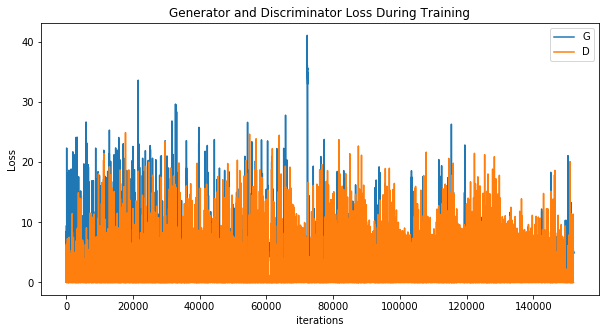

In [346]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

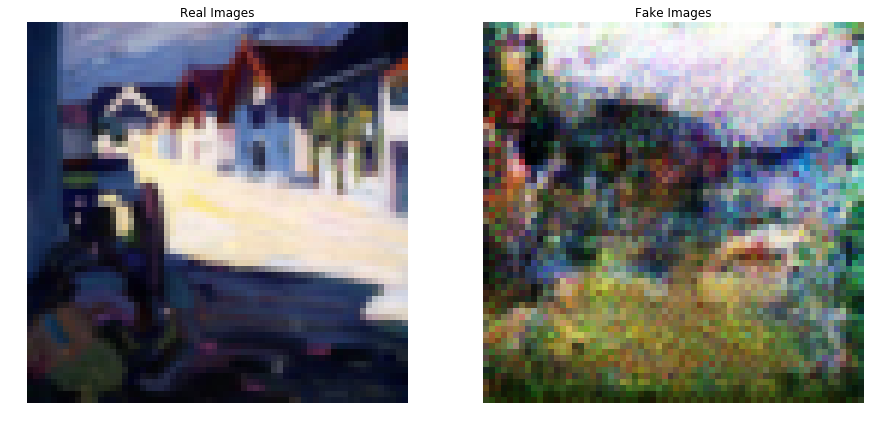

In [347]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1], (1,2,0)))
plt.show()

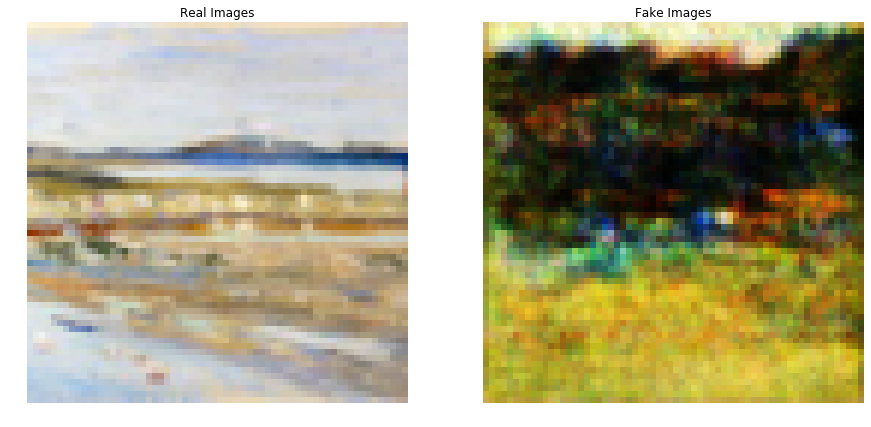

In [362]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[np.random.randint(305)], (1,2,0)))
plt.show()

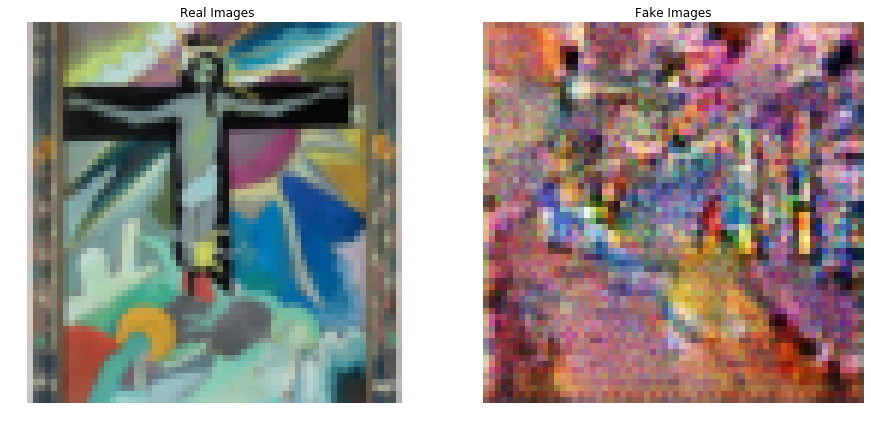

In [367]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[np.random.randint(305)], (1,2,0)))
plt.show()